In [153]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from category_encoders import OneHotEncoder

In [154]:
data=pd.DataFrame(pd.read_json('https://api.apispreadsheets.com/api/dataset/school-grades/',orient='split'))

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

## Inżynieria cech 
### Kodowanie kategoryczne i dodanie kolumny "Czy dostał 0 pkt"

Chcąc lepiej przewidywać wyniki postanowiliśmy inaczej potraktować osoby z zerowym wynikiem. Nasz plan jest taki, aby najpierw przewidywać czy osoba dostanie 0 pkt, a następnie, jeśli z przewidywania wyjdzie że nie powinna dostać 0 pkt, przewidujemy jej wynik.

In [156]:
data['schoolsup'].describe()

count     649
unique      2
top        no
freq      581
Name: schoolsup, dtype: object

Wyrzucamy również kolumne dotyczącą edukacji ojca, gdyż z EDA wyszło nam że jest ona mocno skorelowana z edukacją matki. Postanowiliśmy wyrzucić jedną z tych cech.

In [157]:
data = data.drop(labels = "Fedu", axis = 1)
data = data.drop(labels = "Fjob", axis = 1)

ce_one_hot = OneHotEncoder(cols = ("Mjob", "sex", "school",'famsize',
                                   "address", "Pstatus", "reason",
                                   "guardian", "schoolsup",'famsup', 'paid',
                                   'activities', 'nursery', 'higher', 'internet', 'romantic' ))
df = ce_one_hot.fit_transform(data)

In [158]:
a=df.shape[1]-3
df=df.iloc[:,:a]

In [159]:
data['is_zero']=np.where(data['G3']==0,0,1)

### Main grid search

Na początku dla przetestowania, czy osiągniemy lepsze efekty dzieląc modelowanie na dwa etapy sprawdzamy jakość wybranych modeli bez podziału.

In [160]:
 x_train2, x_test2, y_train2, y_test2 = train_test_split(df, data["G3"],test_size=0.3, random_state=0)

In [161]:
model_params2={
    'linear_regression':{
        'model': linear_model.LinearRegression(),
        'params': {}
    },
    'lasso':{
        'model': linear_model.Lasso(random_state=15),
        'params':{
            'alpha':[0.1,1,0],
            'normalize':['True','False']
        }
    },
    'svm':{
            'model': svm.SVC(gamma='auto', tol=1e-1, cache_size=2000, max_iter=1500),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 3, 10, 30],
                'kernel': ['linear', 'rbf']
            }
    }
}

In [162]:
results2=[]

from sklearn.metrics import mean_squared_error

for name, param in model_params2.items():
    classifier=GridSearchCV(param['model'],param['params'],cv=6,return_train_score=False)
    classifier.fit(x_train2,  y_train2)
    model_performance = np.sqrt(mean_squared_error(classifier.predict(x_test2),y_test2, squared=True))
    results2.append({
        'model': name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'RMSE': model_performance
    })
results2                                                           

[{'model': 'linear_regression',
  'best_score': 0.21178759140058967,
  'best_params': {},
  'RMSE': 2.6490768345339046},
 {'model': 'lasso',
  'best_score': 0.21121308154841392,
  'best_params': {'alpha': 0, 'normalize': 'True'},
  'RMSE': 2.64930062257279},
 {'model': 'svm',
  'best_score': 0.21160818713450294,
  'best_params': {'C': 3, 'kernel': 'rbf'},
  'RMSE': 3.550370150438994}]

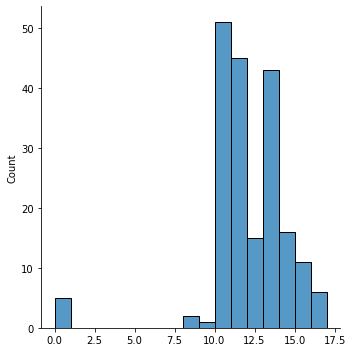

In [163]:
sns.displot(classifier.predict(x_test2))

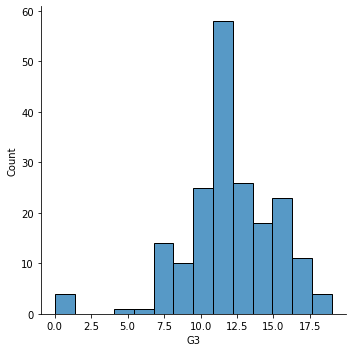

In [164]:
sns.displot(y_test2)

### Grid search: "Czy studenci dostali 0?"

In [165]:
 x_train, x_test, y_train, y_test = train_test_split(df, data["is_zero"],test_size=0.3, random_state=0)

In [166]:
from sklearn import svm

In [167]:
from sklearn.linear_model import LogisticRegression

model_params={
    'random_forest':{
        'model': RandomForestClassifier(random_state=15),
        'params': {
            'n_estimators':[1,3,8,13],
            'min_samples_split': [3,5,10,20]
        }
    },
    'logistic_regession':{
        'model': LogisticRegression(random_state=15, solver='liblinear'),
        'params':{
            'C':[1,5,10],
            'penalty':['l1','l2','elasticnet']
        }
    },
    'svm':{
            'model': svm.SVC(gamma='auto', tol=1e-1, cache_size=2000, max_iter=1500),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 3, 10, 30],
                'kernel': ['linear', 'rbf']
            }
    }
}

In [168]:
results=[]
for name, param in model_params.items():
    classifier=GridSearchCV(param['model'],param['params'],cv=6,return_train_score=False)
    classifier.fit(x_train,  y_train)
    results.append({
        'model': name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_
    })
results

[{'model': 'random_forest',
  'best_score': 0.9757602339181287,
  'best_params': {'min_samples_split': 3, 'n_estimators': 8}},
 {'model': 'logistic_regession',
  'best_score': 0.9779824561403508,
  'best_params': {'C': 1, 'penalty': 'l1'}},
 {'model': 'svm',
  'best_score': 0.977953216374269,
  'best_params': {'C': 10, 'kernel': 'rbf'}}]

In [169]:
only_good_data=df.loc[data.is_zero==1]

In [170]:
data2=data.loc[data.is_zero==1]

In [171]:
 x_train3, x_test3, y_train3, y_test3 = train_test_split(only_good_data, data2["G3"],test_size=0.3, random_state=0)

In [172]:
results3=[]

from sklearn.metrics import mean_squared_error

for name, param in model_params2.items():
    classifier=GridSearchCV(param['model'],param['params'],cv=6,return_train_score=False)
    classifier.fit(x_train3,  y_train3)
    model_performance = np.sqrt(mean_squared_error(classifier.predict(x_test3),y_test3, squared=True))
    results3.append({
        'model': name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'RMSE': model_performance
    })
results3

[{'model': 'linear_regression',
  'best_score': 0.24751458366108417,
  'best_params': {},
  'RMSE': 2.177135660952853},
 {'model': 'lasso',
  'best_score': 0.24764222679510406,
  'best_params': {'alpha': 0, 'normalize': 'True'},
  'RMSE': 2.176658396435847},
 {'model': 'svm',
  'best_score': 0.19196593854128105,
  'best_params': {'C': 30, 'kernel': 'rbf'},
  'RMSE': 2.782706505792912}]

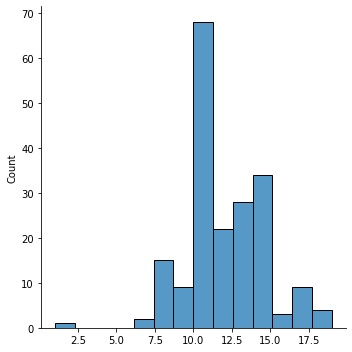

In [173]:
sns.displot(classifier.predict(x_test2))

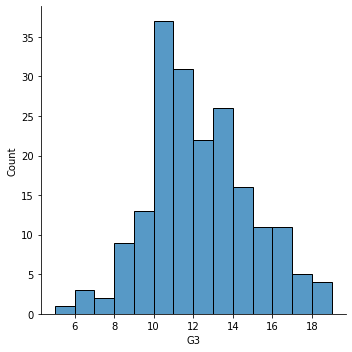

In [174]:
sns.displot(y_test3)